### Historical Shape Indicator (HSI),  Trade Classifier

In [32]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.preprocessing import KBinsDiscretizer
from scipy import stats
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from joblib import dump, load
import pickle

#### Import Generated Trade Data

In [2]:
df_trades = pd.read_csv('trade_gen_5d.csv')
df_trades = df_trades.dropna()
len(df_trades)

38105

In [3]:
# check a sample
df_trades.head()

,HSC,buyday,date,ds1,ds3,ds5,hsi1,hsi3,hsi5,log_ret,...,sd3,sd5,sellday,shift_ret,shp1,shp3,shp5,symbol,trade,mean_ret
0,0.754571,1.0,2014-01-06,1.0,1.0,1.0,0.785996,0.754949,0.754194,-0.022723,...,0.083731,0.093314,0.0,-0.001613,22221.0,33321.0,22331.0,ENTG,1.0,-0.001613
1,0.189724,0.0,2014-01-07,2.0,1.0,1.0,1.000000,0.076317,0.303131,-0.001613,...,0.089412,0.119456,1.0,-0.002188,22212.0,33221.0,22321.0,ENTG,0.0,-0.001613
2,0.774090,1.0,2014-01-09,2.0,2.0,2.0,0.854533,0.693647,0.289821,-0.000669,...,0.145075,0.143138,0.0,0.001120,21222.0,33212.0,23312.0,ENTG,1.0,0.001120
3,0.260765,0.0,2014-01-10,2.0,2.0,2.0,0.701125,0.231710,0.289821,0.001120,...,0.148353,0.141664,1.0,-0.003592,12222.0,32212.0,23312.0,ENTG,0.0,0.001120
4,0.926297,1.0,2014-01-17,1.0,1.0,2.0,0.852595,1.000000,0.205252,-0.010157,...,0.071853,0.094709,0.0,-0.003796,22321.0,21221.0,33122.0,ENTG,1.0,0.001247


In [4]:
print(df_trades.columns)

Index(['HSC', 'buyday', 'date', 'ds1', 'ds3', 'ds5', 'hsi1', 'hsi3', 'hsi5',
       'log_ret', 'pe1', 'pe3', 'pe5', 'proj', 'sd1', 'sd3', 'sd5', 'sellday',
       'shift_ret', 'shp1', 'shp3', 'shp5', 'symbol', 'trade', 'mean_ret'],
      dtype='object')


In [5]:
# estimated price for one day average
df_trades.pe1.describe()

count    38105.000000
mean        49.100547
std         27.964576
min          1.000000
25%         28.343802
50%         44.075000
75%         66.573581
max        150.203229
Name: pe1, dtype: float64

In [6]:
# mean trade returns for trades
df_trades.mean_ret.describe()

count    38105.000000
mean         0.008850
std          0.060114
min         -2.142193
25%         -0.010213
50%          0.003995
75%          0.022899
max          2.380428
Name: mean_ret, dtype: float64

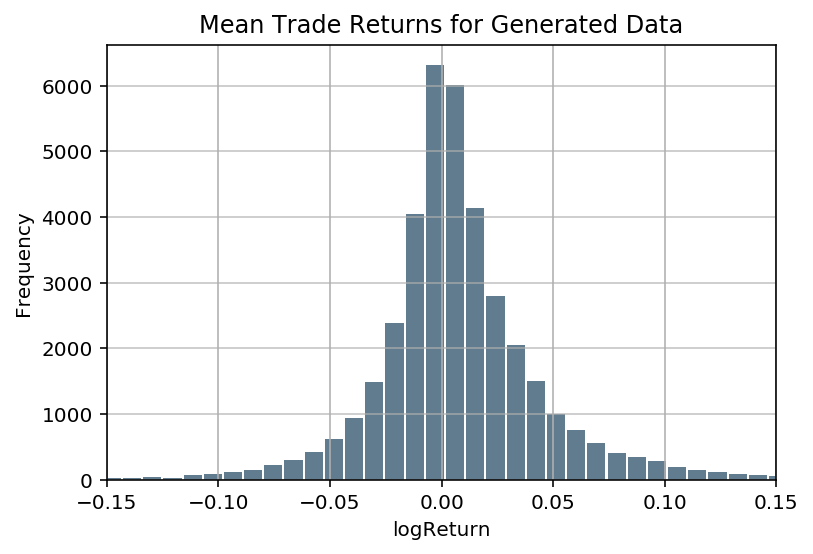

In [7]:
# plot trade returns
df_trades.mean_ret.plot.hist(grid=True, bins=500, rwidth=0.9,
                   color='#607c8e')
plt.title('Mean Trade Returns for Generated Data')
plt.xlabel('logReturn')
plt.ylabel('Frequency')
plt.xlim(-0.15, 0.15)
plt.xticks(np.arange(-0.15, 0.2, step=0.05))
plt.grid(axis='y', alpha=0.75)

#### Clean Data

In [9]:
# Add symbol ordinals
df_trades['sym'] = df_trades['symbol'].astype('category')
df_trades['sym'].cat.categories = np.arange(len(df_trades['symbol'].unique()))
df_trades['sym'] = df_trades['sym'].astype('float')

In [10]:
# Build Symbol to Category Dictionary
symbols = df_trades['symbol'].to_numpy()
sym_cats = df_trades['sym'].to_numpy()
d_symcat = dict(zip(symbols,sym_cats))

# Pickle for use later
with open('dict_symbolcat.pkl', 'wb') as handle:
    pickle.dump(d_symcat, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# add a year column
df_trades.date = pd.to_datetime(df_trades.date)
df_trades['year'] = df_trades['date'].map(lambda x: x.year)

In [12]:
# check for NaN's
df_trades.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38105 entries, 0 to 38104
Data columns (total 27 columns):
HSC          38105 non-null float64
buyday       38105 non-null float64
date         38105 non-null datetime64[ns]
ds1          38105 non-null float64
ds3          38105 non-null float64
ds5          38105 non-null float64
hsi1         38105 non-null float64
hsi3         38105 non-null float64
hsi5         38105 non-null float64
log_ret      38105 non-null float64
pe1          38105 non-null float64
pe3          38105 non-null float64
pe5          38105 non-null float64
proj         38105 non-null float64
sd1          38105 non-null float64
sd3          38105 non-null float64
sd5          38105 non-null float64
sellday      38105 non-null float64
shift_ret    38105 non-null float64
shp1         38105 non-null float64
shp3         38105 non-null float64
shp5         38105 non-null float64
symbol       38105 non-null object
trade        38105 non-null float64
mean_ret     38105 no

In [13]:
# review field names
print(df_trades.columns)

Index(['HSC', 'buyday', 'date', 'ds1', 'ds3', 'ds5', 'hsi1', 'hsi3', 'hsi5',
       'log_ret', 'pe1', 'pe3', 'pe5', 'proj', 'sd1', 'sd3', 'sd5', 'sellday',
       'shift_ret', 'shp1', 'shp3', 'shp5', 'symbol', 'trade', 'mean_ret',
       'sym', 'year'],
      dtype='object')


#### Preprocess

In [14]:
# trade returns
tr = df_trades.mean_ret
# assign quintile categories based on trade returns
trade_cats = pd.qcut(tr,5, labels=[1,2,3,4,5])
# update dataframe with categories
df_trades['opcat'] = trade_cats
# add target category as residing within top two quintiles
df_trades['act'] = ((df_trades['opcat']==5)|(df_trades['opcat']==4))*1

In [44]:
# bin edge for high return odds calculations
edge1 = np.min(df_trades[df_trades['opcat']==4]['mean_ret'])
edge2 = np.max(df_trades[df_trades['opcat']==3]['mean_ret'])
edge = (edge1 + edge2)/2
edge

0.009817309716211087

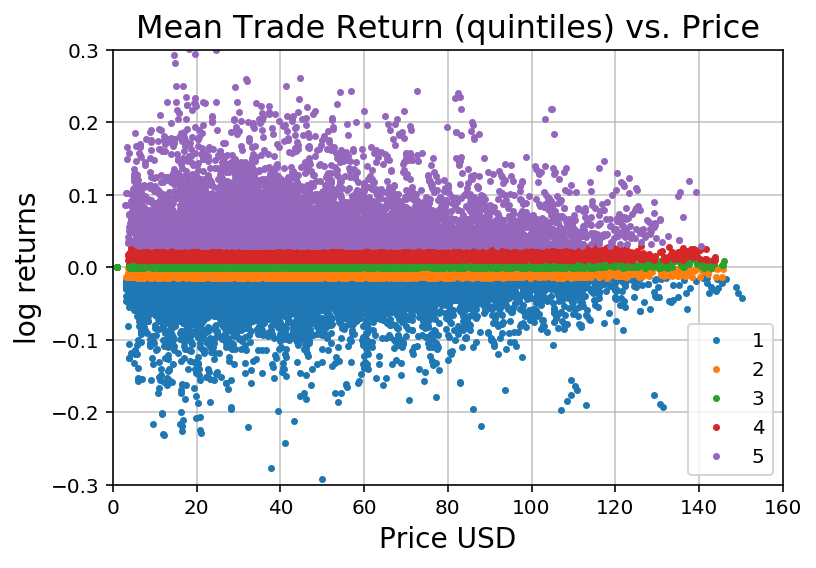

In [15]:
# Quintile Plot of Mean Trade Returns
groups = df_trades.groupby('opcat')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.pe1, group.mean_ret, marker='.', 
            linestyle='', ms=5, label=name)
ax.legend()
plt.xlim(0, 160)
plt.ylim(-0.3,0.3)
plt.title('Mean Trade Return (quintiles) vs. Price',fontsize=16)
plt.xlabel('Price USD',fontsize=14)
plt.ylabel('log returns',fontsize=14)
plt.xticks(np.arange(0, 161, step=20))
plt.grid(alpha=0.75)
plt.show()

#### Data Exploration

In [16]:
# split of high and low returns
df_trades['act'].value_counts()

0    22863
1    15242
Name: act, dtype: int64

In [17]:
# comparison of the two classes
df_trades.groupby('act').mean()

,HSC,buyday,ds1,ds3,ds5,hsi1,hsi3,hsi5,log_ret,pe1,...,sd5,sellday,shift_ret,shp1,shp3,shp5,trade,mean_ret,sym,year
act,,,,,,,,,,,,,,,,,,,,,
0,0.510253,0.526309,1.956655,1.912479,1.897433,0.527284,0.497941,0.484734,-0.001254,49.303197,...,0.654019,0.473691,-0.001373,22268.854262,23135.977562,23706.499191,0.545160,-0.014312,40.900276,2016.414294
1,0.537538,0.575843,2.160412,2.320955,2.391878,0.517728,0.525893,0.534294,0.004563,48.796573,...,0.721101,0.424157,0.004011,22875.757709,23224.818003,23431.323776,0.585291,0.043592,40.148012,2016.579845


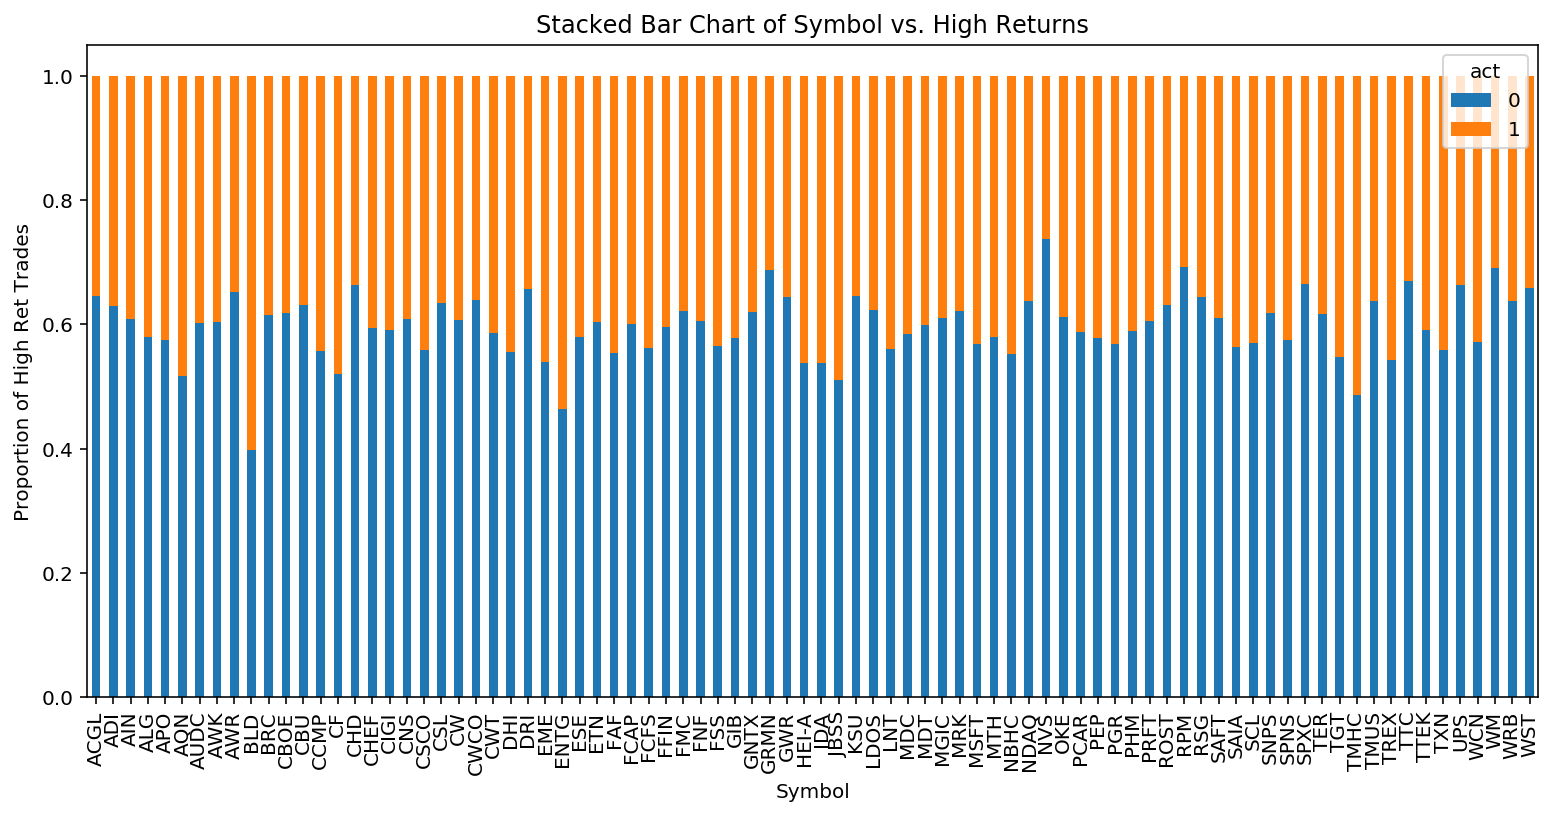

In [18]:
# mean returns by ticker plot
figure(num=None, figsize=(12, 6), dpi=600, facecolor='w', edgecolor='k')
table=pd.crosstab(df_trades.symbol,df_trades.act)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(13, 6))
plt.title('Stacked Bar Chart of Symbol vs. High Returns')
plt.xlabel('Symbol')
plt.ylabel('Proportion of High Ret Trades');

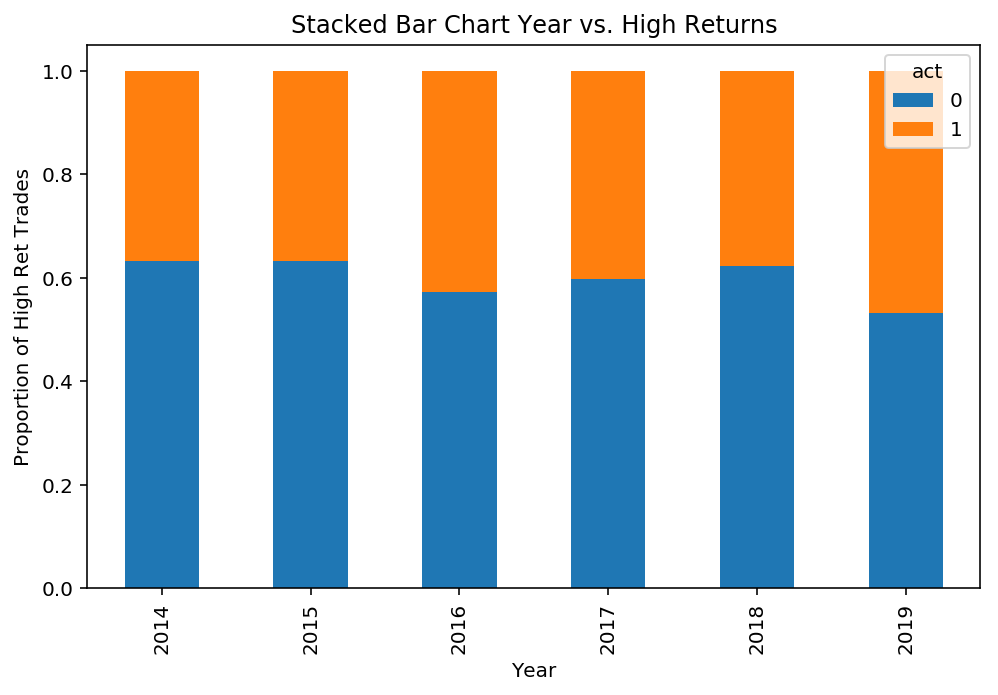

In [19]:
# breakdown by years
figure(num=None, figsize=(12, 6), dpi=600, facecolor='w', edgecolor='k')
table=pd.crosstab(df_trades.year,df_trades.act)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Stacked Bar Chart Year vs. High Returns')
plt.xlabel('Year')
plt.ylabel('Proportion of High Ret Trades');

In [20]:
# features for correlation matrix
cor_cols = ['act','HSC', 
            'ds1', 'ds3', 'ds5',
            'hsi1', 'hsi3', 'hsi5',
            'pe1', 'pe3', 'pe5', 
            'sd1', 'sd3', 'sd5',
            'shp1', 'shp3', 'shp5', 
            'sym','year']

In [21]:
# correlation matrix for feature selection
corr = df_trades[cor_cols].corr()
corr.style.background_gradient(cmap='coolwarm')

,act,HSC,ds1,ds3,ds5,hsi1,hsi3,hsi5,pe1,pe3,pe5,sd1,sd3,sd5,shp1,shp3,shp5,sym,year
act,1,0.0457091,0.156548,0.269062,0.319119,-0.0155967,0.0475092,0.084825,-0.00887541,-0.0044095,-0.000980695,0.0241711,0.0562947,0.0588296,0.0460929,0.00578038,-0.0173958,-0.0151445,0.0481808
HSC,0.0457091,1,0.16059,0.244037,0.218826,0.470887,0.598146,0.556569,-0.00022292,0.00242052,0.00374929,-0.00163825,-0.004543,-0.00779129,-0.0817503,-0.00108075,-0.0154923,0.0111454,0.00181069
ds1,0.156548,0.16059,1,0.575227,0.458099,0.0401411,0.135768,0.154953,0.0314407,0.0331698,0.0334042,-0.0154891,-0.0154084,-0.0171854,-0.00906817,-0.00997864,-0.0095114,0.00909178,0.0269523
ds3,0.269062,0.244037,0.575227,1,0.801368,0.00170529,0.23049,0.270825,0.0203257,0.0276443,0.0299548,-0.0424612,-0.0339807,-0.0320025,-0.0325982,-0.0225721,-0.0202409,-0.000569544,0.0339969
ds5,0.319119,0.218826,0.458099,0.801368,1,-0.0219135,0.168553,0.317883,0.0237883,0.0318063,0.0364207,-0.0464589,-0.041042,-0.038941,0.0775938,-0.0271383,-0.0250825,0.00237055,0.0470694
hsi1,-0.0155967,0.470887,0.0401411,0.00170529,-0.0219135,1,0.0326442,-0.00693318,0.00294925,0.00328436,0.00340396,0.00325421,0.00401257,0.00166824,-0.0502485,0.00704543,0.00276853,0.00768944,-0.0179984
hsi3,0.0475092,0.598146,0.135768,0.23049,0.168553,0.0326442,1,0.158469,0.00449792,0.00660435,0.00745852,0.0069982,0.0027429,0.00269721,-0.0648404,-0.00328946,0.0044971,0.00805722,0.00693483
hsi5,0.084825,0.556569,0.154953,0.270825,0.317883,-0.00693318,0.158469,1,0.00720472,0.0100834,0.0118019,-0.00491977,-0.00983586,-0.0130729,-0.0214504,-0.0104762,-0.0322216,4.31778e-05,0.0255183
pe1,-0.00887541,-0.00022292,0.0314407,0.0203257,0.0237883,0.00294925,0.00449792,0.00720472,1,0.999801,0.999527,0.584186,0.591926,0.597086,0.0433879,0.0531968,0.0523415,0.122895,0.448074
pe3,-0.0044095,0.00242052,0.0331698,0.0276443,0.0318063,0.00328436,0.00660435,0.0100834,0.999801,1,0.999882,0.583943,0.592016,0.597193,0.0431146,0.0527021,0.0520185,0.122759,0.44856


In [22]:
# format datatypes for training
data_final = df_trades[cor_cols].copy()
data_final['act'] = data_final['act'].astype(float)
data_final['year'] = data_final['year'].astype(float)

In [23]:
# double check data types
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38105 entries, 0 to 38104
Data columns (total 19 columns):
act     38105 non-null float64
HSC     38105 non-null float64
ds1     38105 non-null float64
ds3     38105 non-null float64
ds5     38105 non-null float64
hsi1    38105 non-null float64
hsi3    38105 non-null float64
hsi5    38105 non-null float64
pe1     38105 non-null float64
pe3     38105 non-null float64
pe5     38105 non-null float64
sd1     38105 non-null float64
sd3     38105 non-null float64
sd5     38105 non-null float64
shp1    38105 non-null float64
shp3    38105 non-null float64
shp5    38105 non-null float64
sym     38105 non-null float64
year    38105 non-null float64
dtypes: float64(19)
memory usage: 5.8 MB


In [24]:
# assign target and features
X = data_final.loc[:, data_final.columns != 'act']
y = data_final.loc[:, data_final.columns == 'act']
len(X),len(y)

(38105, 38105)

In [25]:
# initiate over-sampling
os = SMOTE(random_state=0)

In [26]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

In [27]:
# apply over-sampling
os_data_X,os_data_y=os.fit_sample(X_train, y_train.values.ravel())
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['act'])
len(os_data_X), len(os_data_y)

(31944, 31944)

In [28]:
# check over-sampling
print("length of oversampled data is ",
      len(os_data_X))
print("Number of low-ret class in oversampled data",
      len(os_data_y[os_data_y['act']==0]))
print("Number of hi-ret class",
      len(os_data_y[os_data_y['act']==1]))

length of oversampled data is  31944
Number of low-ret class in oversampled data 15972
Number of hi-ret class 15972


In [29]:
# instantiate model and check Recursive Feature Elimination
logreg = LogisticRegression(random_state=0, solver='lbfgs',
                            multi_class='multinomial',
                           ).fit(os_data_X, os_data_y.values.ravel())
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [30]:
# model accuracy score for reporting purposes
logreg.score(X_test,y_test)

0.6507172848145556

In [31]:
# model predictions
y_pred = logreg.predict(X_test)

In [33]:
# classification report
target_names = ['Low_Ret', 'High_Ret']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Low_Ret       0.73      0.67      0.70      6891
    High_Ret       0.55      0.62      0.58      4541

    accuracy                           0.65     11432
   macro avg       0.64      0.64      0.64     11432
weighted avg       0.66      0.65      0.65     11432



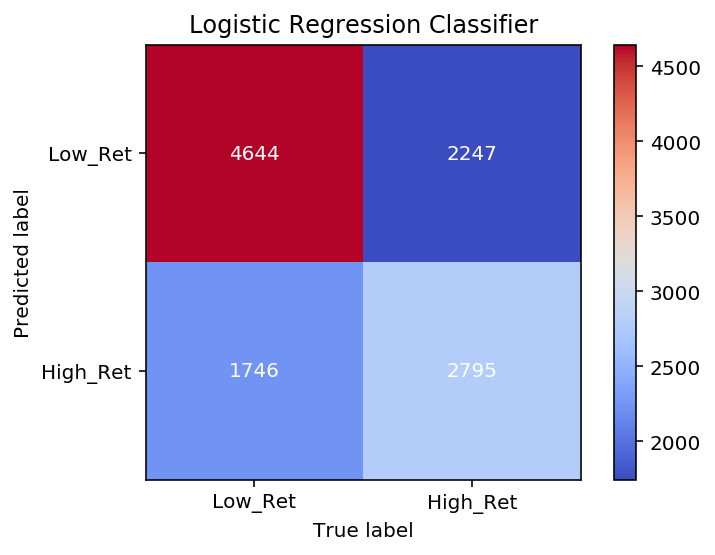

In [34]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm.T, interpolation='nearest', 
               cmap='coolwarm')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, "{:.0f}".format(cm[i,j]), 
                ha="center", va="center", color="w")
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[0]),
       yticks=np.arange(cm.shape[1]),
       xticklabels=target_names, 
       yticklabels=target_names,
       title='Logistic Regression Classifier',
       ylabel='Predicted label',
       xlabel='True label');

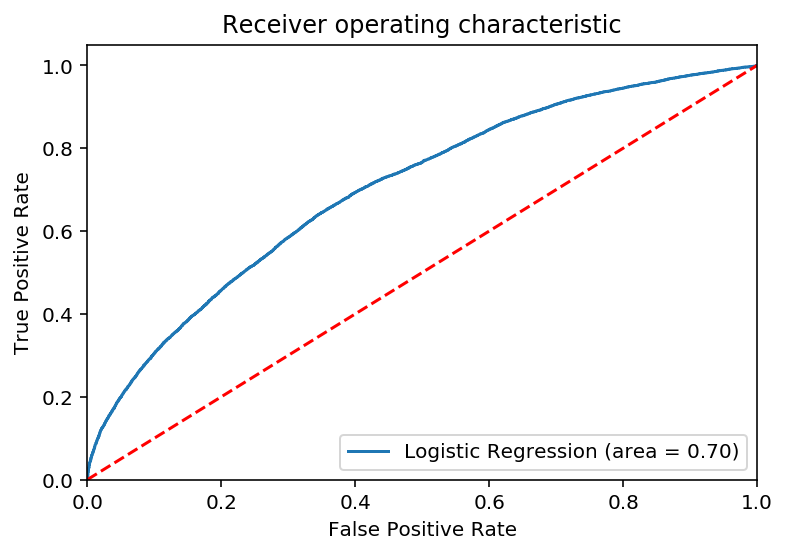

In [63]:
# ROC curve
trues = df_trades['act'].to_numpy()
probs = df_trades['prob']
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(trues, probs)
fpr, tpr, thresholds = roc_curve(trues, probs)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Evaluate Classifier Trade Return Performance

In [35]:
# find hi return prediction indices
df_eval = X_test.copy()
df_eval['pred'] = y_pred
df_hi = df_eval[df_eval['pred']==1].copy()
hi_idx= df_hi.index.tolist()

In [36]:
# verify no duplicates
len(hi_idx),len(set(hi_idx))

(5042, 5042)

In [37]:
# add classifications to trades
class_cols = X_test.columns
df_class = df_trades[class_cols].copy()
df_trades['pred'] = logreg.predict(df_class)
df_trades['prob'] = logreg.predict_proba(df_class).T[1]

In [38]:
# check test case length unchanged
df_pred = df_trades.loc[hi_idx].copy()
len(df_pred)

5042

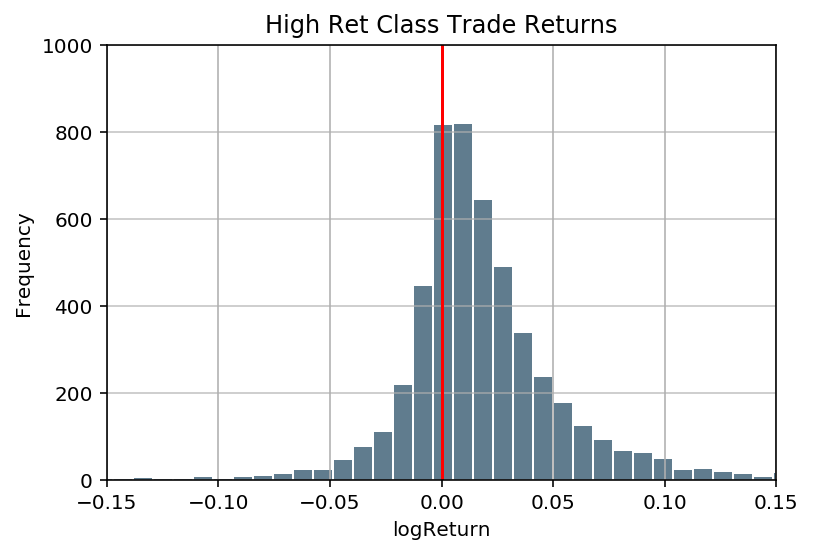

In [40]:
# plot "High Ret" trade returns
df_pred.mean_ret.plot.hist(grid=True, 
                bins=300, rwidth=0.9, color='#607c8e')
plt.title('High Ret Class Trade Returns')
plt.xlabel('logReturn')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r')
plt.ylim(0,1000)
plt.xlim(-0.15, 0.15)
plt.xticks(np.arange(-0.15, 0.2, step=0.05))
plt.grid(axis='y', alpha=0.75)

In [49]:
# odds ratio of positive return
len(df_pred[df_pred['mean_ret']>=0])/len(df_pred[df_pred['mean_ret']<0])

2.923735408560311

The odds ratio of making a positive return shifted from 1.37:1, to 2.92:1

In [55]:
# odds ratio of positive return
len(df_pred[df_pred['mean_ret']>=edge])/len(df_pred[df_pred['mean_ret']<edge])

1.2438807298620382

In [50]:
# find low return prediction indices
df_low = df_eval[df_eval['pred']==0].copy()
low_idx= df_low.index.tolist()

In [51]:
# verify no duplicates
len(low_idx),len(set(low_idx))

(6390, 6390)

In [52]:
# verify index length
df_not = df_trades.loc[low_idx].copy()
len(df_low)

6390

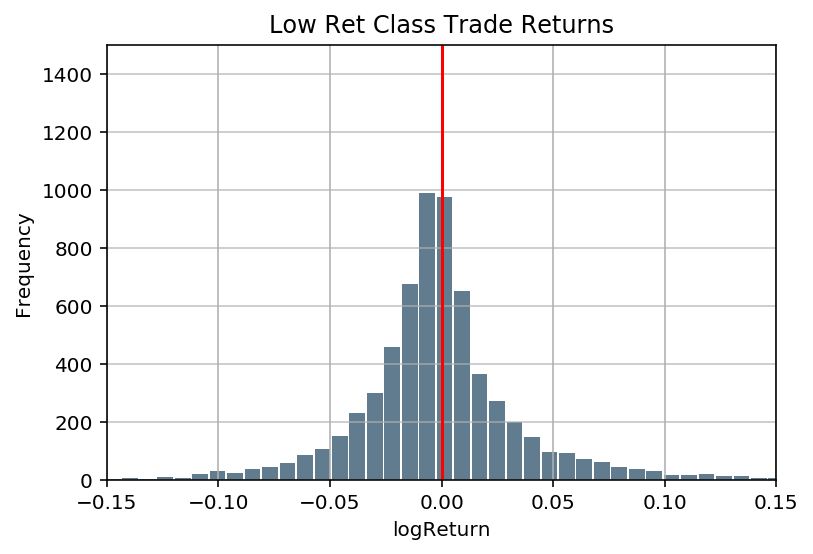

In [53]:
# plot "Low Ret" trade returns
df_not.mean_ret.plot.hist(grid=True, 
                bins=300, rwidth=0.9, color='#607c8e')
plt.title('Low Ret Class Trade Returns')
plt.xlabel('logReturn')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r')
plt.xlim(-0.15, 0.15)
plt.ylim(0,1500)
plt.xticks(np.arange(-0.15, 0.2, step=0.05))
plt.grid(axis='y', alpha=0.75)

In [54]:
# odds of making a positive return trade
len(df_not[df_not['mean_ret']>0])/len(df_not[df_not['mean_ret']<=0])

0.7764804003336113

In [56]:
# odds of making a high return trade
len(df_not[df_not['mean_ret']>edge])/len(df_not[df_not['mean_ret']<=edge])

0.375968992248062

In [57]:
# no classification comparison
all_idx= df_eval.index.tolist()

In [58]:
# check duplicates
len(all_idx),len(set(all_idx))

(11432, 11432)

In [59]:
# verify indexing
df_noclass = df_trades.loc[all_idx].copy()
len(df_noclass)

11432

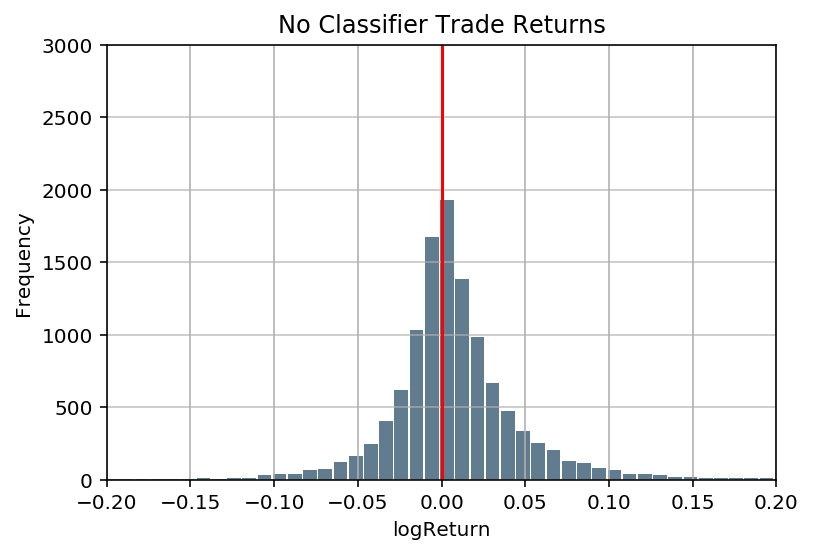

In [60]:
# plot no classifier trade returns
df_noclass.mean_ret.plot.hist(grid=True, 
                bins=300, rwidth=0.9, color='#607c8e')
plt.title('No Classifier Trade Returns')
plt.xlabel('logReturn')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r')
plt.xlim(-0.2, 0.2)
plt.ylim(0,3000)
plt.xticks(np.arange(-0.2, 0.25, step=0.05))
plt.grid(axis='y', alpha=0.75)

In [61]:
# odds of positive return for no classification
len(df_noclass[df_noclass['mean_ret']>0])/len(df_noclass[df_noclass['mean_ret']<=0])

1.3383104929433423

In [62]:
# odds of high return given no classification
len(df_noclass[df_noclass['mean_ret']>edge])/len(df_noclass[df_noclass['mean_ret']<=edge])

0.6589754752575824

#### Using the Classifier to Rank Trades

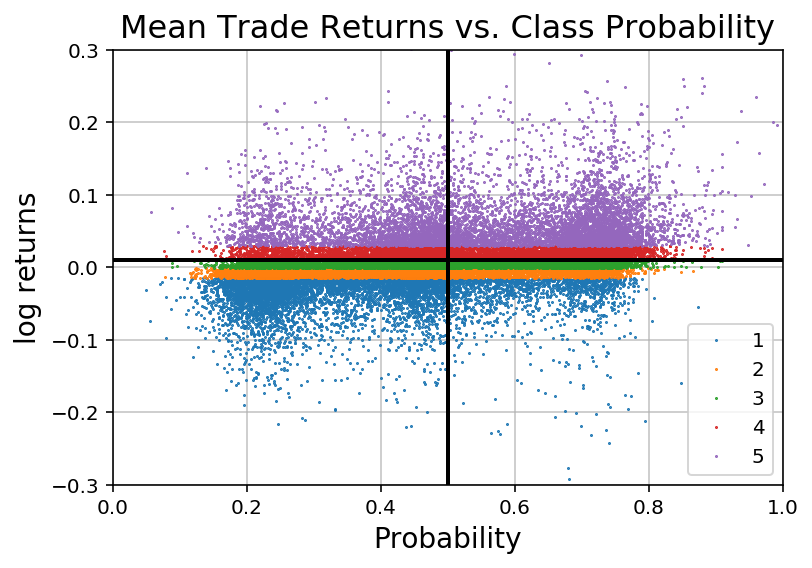

In [72]:
# Quintile Plot of Mean Trade Returns
groups = df_trades.groupby('opcat')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.prob, group.mean_ret, marker='.', 
            linestyle='', ms=1, label=name)
ax.legend()
plt.axvline(x=0.5, linewidth=2, color='black')
plt.axhline(y=edge, linewidth=2, color='black')
plt.xlim(0, 1)
plt.ylim(-0.3,0.3)
plt.title('Mean Trade Returns vs. Class Probability',fontsize=16)
plt.xlabel('Probability',fontsize=14)
plt.ylabel('log returns',fontsize=14)
#plt.xticks(np.arange(0, 1, step=0.1))
plt.grid(alpha=0.75)
plt.show()

#### Export Classifier Model

In [64]:
# export for daily etl
dump(logreg, 'logreg_model.joblib')
# clf = load('logreg_model.joblib')

['logreg_model.joblib']

### Disclaimer: this notebook is intended for educational purposes only and not recommended for real trading.